# Avaliando resultados do produto

Nesse notebook vamos avaliar o resultado dos modelos para predição de churn. Temos três modelos para análise:

- Heuristico: Utiliza as features base (`tipo_de_empresa`,`fundação_da_empresa`, `possui_mais_de_um_sócio`,`funcionários`, `meses_de_permanência`, `utiliza_serviços_financeiros`,`possuicontador`,`faz_conciliação_bancária`,        `frequência_de_utilização_de_feature_do_sistema_módulo_financeiro`, `frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal`,          `frequência_de_utilização_de_feature_do_sistema_integração_bancária`,          
`frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas`,                   
`frequência_de_utilização_de_feature_do_sistema_relatórios`,                      `frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração` ,
`contrato`,`emite_boletos`,`tipo_de_pagamento`,`receita_mensal`,`receita_total`,`clf_meses_de_permância`,`qty_PoucoUso_features`) e aplica a seguinte regra de negócio: realiza churn se empresa tem tempo de permanência menor que 12 meses e quantidade de features pouco utilizadas menor ou igual a 3.
- Decision Forest: Utiliza as features base e aplica uma árvore de decisão para definir churn.
- Random forest: Baseado em multíplas árvores de decisão e utiliza as features base mais features construídas pelo processo de feature engineering.

Dessa forma, vamos verificar o ganho de cada modelo em relação a f1-score, precision e recall, ganho e perdas de receita e saber qual o impacto das features escolhidas no modelo otimizado. 

In [2]:
import os
os.chdir("../")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.impute import SimpleImputer
from typing import Union
from helper import *
from src.features import *
from src.models import make_predict
from src.data.make_dataset import make_pipeline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 2 - Leitura dos dados

In [4]:
train_data = pd.read_csv("./data/processed/train_data.csv")
test_data = pd.read_csv("./data/processed/test_data.csv")

CAT_FEATS = train_data.select_dtypes(include="object",exclude=["int64","float64"]).columns.to_list()
train_data = convert_to_categoric(train_data,subset=CAT_FEATS)
test_data = convert_to_categoric(test_data,subset=CAT_FEATS)
test_data.dtypes

tipo_de_empresa                                                                    category
possui_mais_de_um_sócio                                                            category
funcionários                                                                       category
utiliza_serviços_financeiros                                                       category
possuicontador                                                                     category
faz_conciliação_bancária                                                           category
frequência_de_utilização_de_feature_do_sistema_módulo_financeiro                   category
frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal              category
frequência_de_utilização_de_feature_do_sistema_integração_bancária                 category
frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas                    category
frequência_de_utilização_de_feature_do_sistema_relatórios                       

## 2 - Tratamento dos dados para predição

In [5]:
## create features for random forest model

list_funcs = [
    {
        "function":create_missing_indicator
    },
    {
        "function":count_class_frequency,
        "function_kwargs":{
            "class_to_count": "Uso frequente",
            "columns": [
                "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
                "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
                "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
                "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
                "frequência_de_utilização_de_feature_do_sistema_relatórios",
                "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração"
            ]
        }
    },
    {
        "function":create_eq_or_gt_feature,
        "function_kwargs":{
            "feature_name":"is_receita_mensal_maior_ou_igual_70",
            "value":70.0,
            "columns":"receita_mensal"
        }
    }

]

train_data_rf = make_pipeline(dataframe=train_data,functions=list_funcs)
test_data_rf = make_pipeline(dataframe=test_data,functions=list_funcs)

In [6]:
## X_train, y_train and X_test, y_test for baseline models 

NUM_FEATURES = list(train_data.select_dtypes(include=["int64","float64"],exclude="category").columns)
CAT_FEATURES = list(train_data.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
TARGET = "churn"
NUM_FEATURES.remove(TARGET)


X_train = train_data[NUM_FEATURES+CAT_FEATURES]
y_train = train_data[TARGET]
X_test = test_data[NUM_FEATURES+CAT_FEATURES]
y_test = test_data[TARGET]

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("y_train para predição de Churn e não churn:",y_train.value_counts(normalize=True))
print("y_test proporção de Churn e não churn:",y_test.value_counts(normalize=True))

X_train, y_train shape: ((5634, 21), (5634,))
X_test, y_test: ((1409, 21), (1409,))
X_test, y_test: ((1409, 21), (1409,))
y_train para predição de Churn e não churn: churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64
y_test proporção de Churn e não churn: churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


In [7]:
## X_train, y_train and X_test, y_test for random forest models
NUM_FEATURES_RF = list(train_data_rf.select_dtypes(include=["int64","float64"],exclude="category").columns)
CAT_FEATURES_RF = list(train_data_rf.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
TARGET = "churn"
NUM_FEATURES_RF.remove(TARGET)


X_train_rf = train_data_rf[NUM_FEATURES_RF+CAT_FEATURES_RF]
y_train_rf = train_data_rf[TARGET]
X_test_rf = test_data_rf[NUM_FEATURES_RF+CAT_FEATURES_RF]
y_test_rf = test_data_rf[TARGET]

print("X_train_rf, y_train_rf shape:",(X_train_rf.shape,y_train_rf.shape))
print("X_test_rf, y_test:",(X_test_rf.shape,y_test_rf.shape))
print("X_test_rf, y_test:",(X_test_rf.shape,y_test_rf.shape))
print("y_test_rf proporção de Churn e não churn:",y_test_rf.value_counts(normalize=True))

X_train_rf, y_train_rf shape: ((5634, 25), (5634,))
X_test_rf, y_test: ((1409, 25), (1409,))
X_test_rf, y_test: ((1409, 25), (1409,))
y_test_rf proporção de Churn e não churn: churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


## 3 - Aplicando predicts para modelos

In [9]:
# carregando parametros dos modelos 

with open("./config/decision_tree_clf_for_churn_config.yaml","r") as dt_config_f:
    cfg_dt = yaml.safe_load(dt_config_f)

with open("./config/random_forest_clf_for_churn_config.yaml","r") as rf_config_f:
    cfg_rf = yaml.safe_load(rf_config_f)

In [10]:
# construindo pipelines

## get features
DT_CAT_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_dt["model_features"]["CAT_FEATURES"]]
DT_NUM_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_dt["model_features"]["NUM_FEATURES"]]

RF_CAT_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_rf["model_features"]["CAT_FEATURES"]]
RF_NUM_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_rf["model_features"]["NUM_FEATURES"]]


## construct preprocessors
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), DT_NUM_FEATURES),
        ('cat', OneHotEncoder(), DT_CAT_FEATURES)])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), RF_NUM_FEATURES),
        ('cat', OneHotEncoder(), RF_CAT_FEATURES)])

## use feature selection for random forest 
arr_selected_features = cfg_rf["model_parameters"]["fs_params"]["select_cols_arr"]
col_selector = ColumnTransformer(
    transformers=[("select_cols","passthrough",arr_selected_features)]
)

# Define the pipelines
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model',DecisionTreeClassifier(**cfg_dt["model_parameters"]["fit_params"]))  # Model
])
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),  # Preprocessing (imputation + one-hot encoding),
    ("select_cols",col_selector),
    ('model', RandomForestClassifier(**cfg_rf["model_parameters"]["fit_params"]))  # Model
])

In [12]:
## FIT THE MODELS 
dt_model = dt_pipeline.fit(X_train,y_train)
rf_model = rf_pipeline.fit(X_train_rf,y_train_rf)

In [13]:
heuristic_predict = ((X_test["qty_PoucoUso_features"]>=3)&(
    (X_test["clf_meses_permanência"]=="Menos que 3 meses")|
    (X_test["clf_meses_permanência"]=="Entre 3 a 12 meses")
)).map({False:0,True:1})

dt_y_pred_proba,dt_y_pred = make_predict(model=dt_model,X_test=X_test,return_classes=True)

BEST_TH_RF = cfg_rf["model_parameters"]["predict_params"]["decision_threshold"]
rf_y_pred_proba,rf_y_pred = make_predict(X_test=X_test_rf,model=rf_model,return_classes=True,threshold=BEST_TH_RF)

## 4 - Realizando as análises

Feito o carregamento dos modelos vamos avaliar agora os resultados

### 4.1 - Comparando f1-score, precision e recall

In [14]:
all_preds = {"random_forest":rf_y_pred,"decision_tree":dt_y_pred,"heuristic":heuristic_predict}
all_metrics = {model:classification_report(y_test,y_pred,output_dict=True)["1"] for model,y_pred in all_preds.items()}
df_all_metrics = pd.DataFrame.from_dict(all_metrics).T

,precision,recall,f1-score,support
random_forest,0.578000,0.774799,0.662085,373.0
decision_tree,0.502732,0.493298,0.497970,373.0
heuristic,0.484848,0.214477,0.297398,373.0


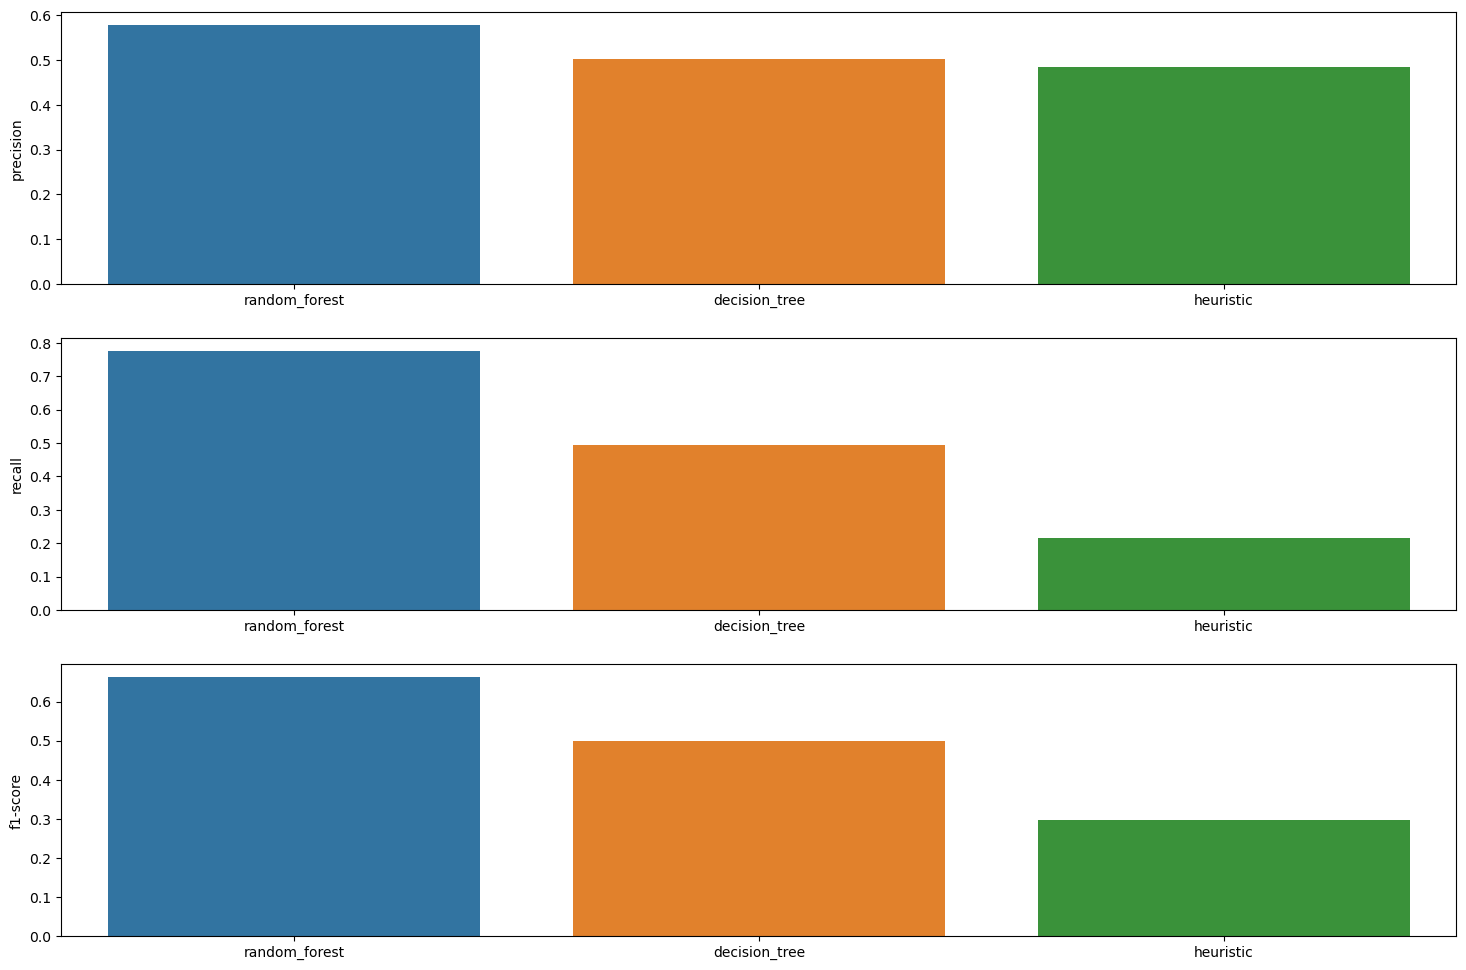

In [15]:
fig,axes = plt.subplots(3,1,figsize=(18,12))
for col,ax in zip(df_all_metrics.columns,axes):
    sns.barplot(data=df_all_metrics,x=df_all_metrics.index,y=col,ax=ax);

df_all_metrics

Em relação as métricas, vemos que o random forest conseguiu um desempenho superior ao modelo heuristíco e decision tree. Em percentuais calculamos:
- A precision para a random forest obteve ganho de 19.4% para o modelo heuristico e 15.1% ao decision tree.
- O recall cresceu em 57% em relação a decision tree e 261.7% em relação ao heurístico.
- Já em relação a f1-score temos 33% em relação a decision tree e 123% em relação ao heurístico.

O modelo de random forest se mostra uma boa solução justamente por ter uma f1-score e recall pois significa que temos poucos falsos negativos e falsos positivos sendo previstos 

## 4.2 - Avaliação de ganho de receita total do modelo otimizado

Cada empresa tem uma receita total associada conforme nossa precisão aumenta para prever o churn maior é o ganho que obtemos em receita.  Dessa forma, vamos avaliar abaixo o ganho que temos do modelo otimizado.

,receita_total
random_forest,320590.35
decision_tree,193840.85
heuristic,34878.30


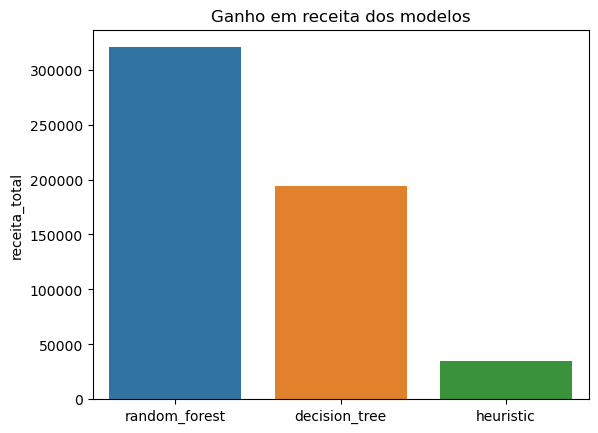

In [16]:
idxs_all_correct_preds = {model:y_test == y_pred for model,y_pred in all_preds.items()}
all_churn_preds = {
    "random_forest":y_test_rf[idxs_all_correct_preds["random_forest"]].eq(1),
    "heuristic":y_test[idxs_all_correct_preds["heuristic"]].eq(1),
    "decision_tree":y_test[idxs_all_correct_preds["decision_tree"]].eq(1)
}


sum_all_receitas_totais = {
    "random_forest":X_test_rf[idxs_all_correct_preds["random_forest"]]["receita_total"].loc[all_churn_preds["random_forest"]].agg("sum"),
    "decision_tree":X_test[idxs_all_correct_preds["decision_tree"]]["receita_total"].loc[all_churn_preds["decision_tree"]].agg("sum"),
    "heuristic":X_test[idxs_all_correct_preds["heuristic"]]["receita_total"].loc[all_churn_preds["heuristic"]].agg("sum"),

}

df_all_correct_preds_receitas_totais = pd.DataFrame(sum_all_receitas_totais,index=["receita_total"]).T

fig,ax = plt.subplots()
sns.barplot(data=df_all_correct_preds_receitas_totais,x=df_all_correct_preds_receitas_totais.index,y="receita_total");
ax.set_title("Ganho em receita dos modelos");
df_all_correct_preds_receitas_totais

Podemos verificar que a random_forest trouxe um ganho maior em receita justamente por ela acertar mais resultados. Em percentuais, ela trouxe 65.3% a mais de receita em comparação com a decision tree e 819% em comparação ao heurístico. Contudo, esse valor desconsidera os erros de falso positivos do modelo (aquele caso que se previu o churn mas não se realizou o churn), isso porque eles representam o custo do modelo. Prever um caso como falso positivo é ruim pois se aumenta o gasto para manter o cliente. Então, queremos um modelo que mantenha esse valor baixo. Vamos avaliar, a seguir, o quanto de perda em receitas nós obtemos com os modelos.

,receita_total
random_forest,209617.05
decision_tree,336366.55
heuristic,495329.10


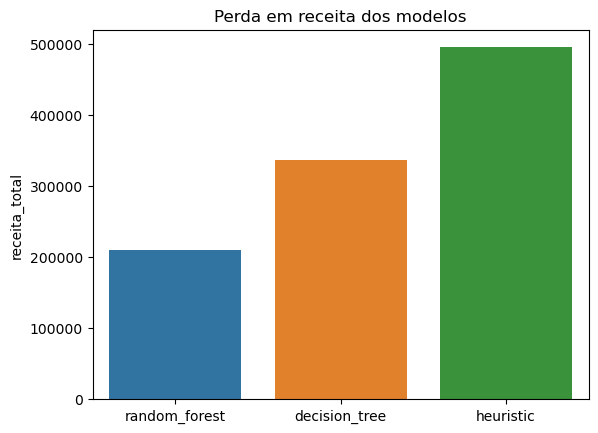

In [18]:
idxs_errs_churn_preds = {model:preds.eq(False) for model,preds in idxs_all_correct_preds.items()}

all_errchurn_preds = {
    "random_forest":y_test_rf[idxs_errs_churn_preds["random_forest"]].eq(1),
    "heuristic":y_test[idxs_errs_churn_preds["heuristic"]].eq(1),
    "decision_tree":y_test[idxs_errs_churn_preds["decision_tree"]].eq(1)
}


sum_all_errchurn_receitas_all = {
    "random_forest":X_test_rf[idxs_errs_churn_preds["random_forest"]]["receita_total"].loc[all_errchurn_preds["random_forest"]].agg("sum"),
    "decision_tree":X_test[idxs_errs_churn_preds["decision_tree"]]["receita_total"].loc[all_errchurn_preds["decision_tree"]].agg("sum"),
    "heuristic":X_test[idxs_errs_churn_preds["heuristic"]]["receita_total"].loc[all_errchurn_preds["heuristic"]].agg("sum"),

}

df_all_errchurn_receitas_all = pd.DataFrame(sum_all_errchurn_receitas_all,index=["receita_total"]).T

fig,ax = plt.subplots()
sns.barplot(data=df_all_errchurn_receitas_all,x=df_all_errchurn_receitas_all.index,y="receita_total");
ax.set_title("Perda em receita dos modelos");
df_all_errchurn_receitas_all

O random_forest apresentou a menor perda em comparação com os modelos baselines (cerca de 37.7% a menos em comparação com a decision tree e 57.9% em relação ao modelo heurístico). Justamente, por ele ter o maior precision entre os modelos baselines.

,receita_total
random_forest,110973.3
decision_tree,-142525.7
heuristic,-460450.8


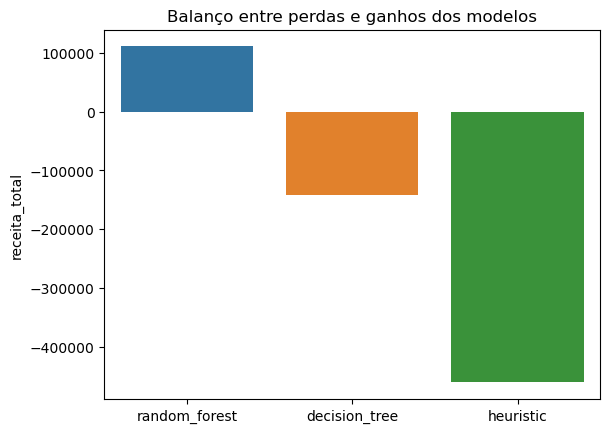

In [19]:
df_balanc_geral = df_all_correct_preds_receitas_totais.sub(df_all_errchurn_receitas_all)

fig,ax = plt.subplots()
sns.barplot(data=df_balanc_geral,x=df_balanc_geral.index,y="receita_total");
ax.set_title("Balanço entre perdas e ganhos dos modelos");
df_balanc_geral


Conforme podemos analisar, descontada as perdas, vemos que o modelo random_forest se mostrou com ganho em receita acima de 100k (cerca de 34.62% da receita total gerada), enquanto os demais apresentaram perdas financeiras consideraveis (o heurístico chegando a mais de 400k de prejuízo). 

## 5 - Avaliando a importância das features 

Como último parametro para análise vamos avaliar a importância das features do random_forest, para isso, será utilizado o SHAP que é um gráfico que mostra as features mais importantes para modelo e considerando o impacto que uma alteração do valor da feature gera no output do modelo.

In [20]:
X_train_rf_t = rf_model.named_steps["preprocessor"].transform(X_train_rf)
X_train_rf_t = rf_model.named_steps["select_cols"].transform(X_train_rf_t)
output_feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out()[arr_selected_features]
shap_values = shap.explainers.Tree(rf_model.named_steps["model"]).shap_values(X_train_rf_t)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


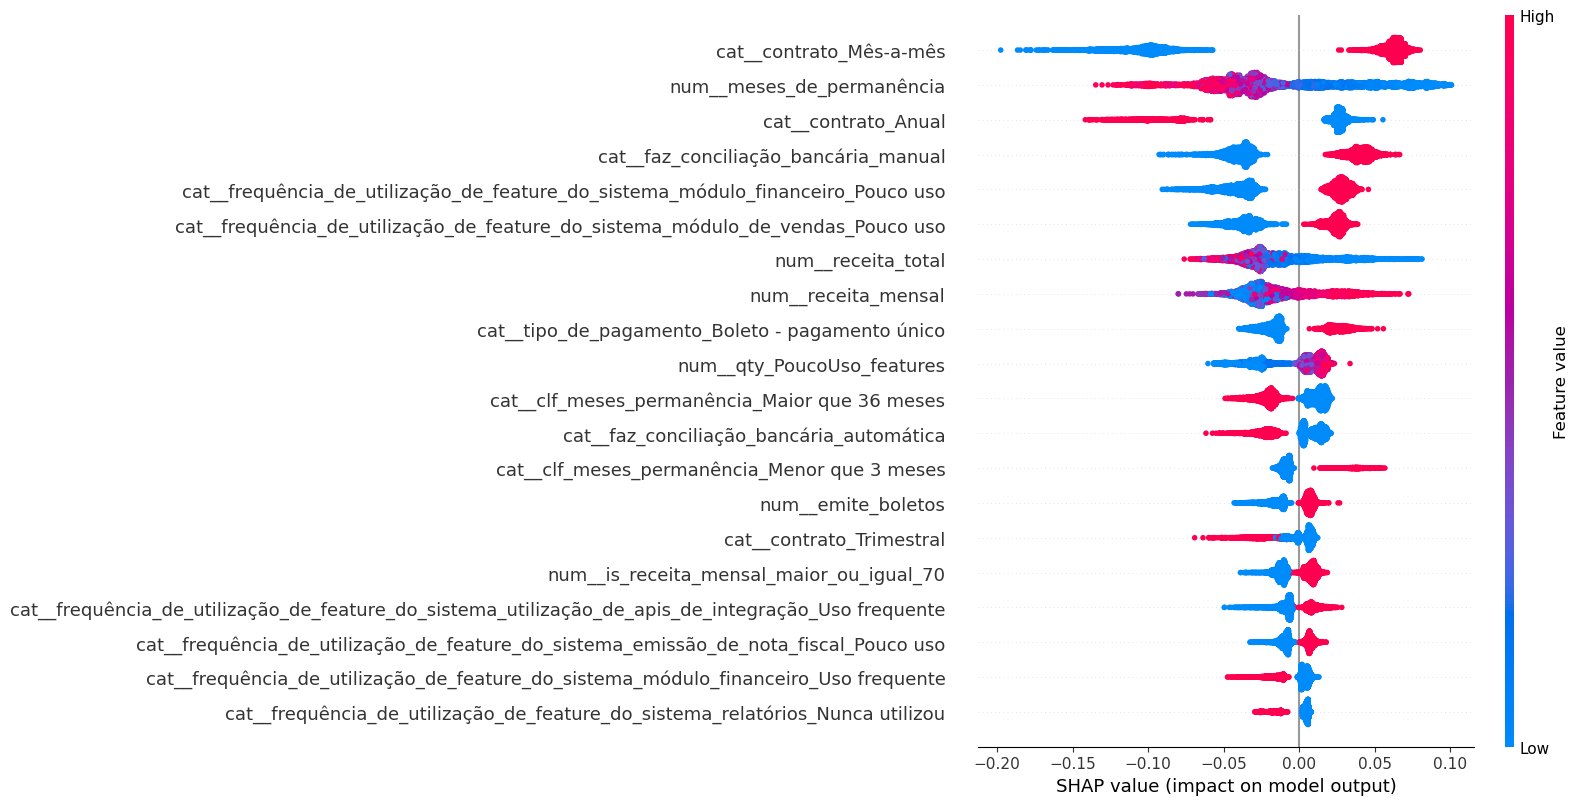

In [24]:
f = plt.figure()
df_X_train_rf_t = pd.DataFrame(X_train_rf_t,columns=output_feature_names)
shap.summary_plot(shap_values[1],df_X_train_rf_t)

Pelo shap podemos perceber algumas características aprendidas pelo modelo como detectar que clientes que realizam churn tem tendência a ter um alto valor de receita mensal mas baixo de receita total isso porque quando visto o tempo de permanência na empresa ele é curto, além disso, quando o contrato tem característica de ser mês a mês e as features de módulo financeiro e módulo de vendas são pouco utilizadas, maior é a tendência ao churn.

Por outro lado, o cliente sem tendência ao churn pelo modelo é visto como aquele tem tempo maior de permanência na empresa, eles tendem a ter um contrato anuala/trimestral, eles geram uma receita total alta apesar de ter um gasto mensal baixo, ele utiliza bastante a feature de módulo financeiro, sendo essa, a mais importante das features nesse caso por ser que seu uso frequente alto tem impacto para não previsão do churn.

Para futuras melhorias é possível realizar a união de algumas features categóricas principalmente aquelas que falam sobre frequência de utilização da plataforma como as features de módulo financeiro e módulo de vendas podem ser combinadas como frequencia_PoucoUso_modulo_financeiro_e_modulo_de_vendas por exemplo. 

Além disso, seria interessante ter essas variáveis sobre frequência de utilização da plataforma de acordo com o tempo, como frequência_de_uso_nos_ultimos_30_dia_modulo_financeiro, isso porque conseguiriamos acompanhar as features mais relevantes para o cliente conforme se avança no contrato.

## 6 - Conclusão

- Avaliando os resultados, verificamos que o modelo obtido conseguiu apresentar grandes ganhos na predição de Churn, com um ganho em receita nos dados de teste maior que 100k.
- A f1-score do modelo otimizado conseguiu chegar a 0.66 sendo 33% e 123% maior do que a f1-score do modelo da decision tree e do modelo heurístico.
- Pelo gráfico de importância das features, podemos observar que variáveis relacionadas ao tipo de contrato, frequência de utilização das features, receita mensal e total tem grande importância ao definir o output do modelo. É possível a partir disso gerar métricas como quantidade de clientes com contrato maior do que três meses, saber quais as features com mais utilização e pouca utilização ou qual é o valor médio mensal que os clientes estão gastando. 
- Para futuras melhorias, podemos trabalhar melhor a geração de features, acompanhando a variação do uso das features ao longo do tempo e combinar mais dados como tipo_de_contrato_trimestral e faz_conciliação_bancaria_automática.